In [1]:
pip install lifelines

     |████████████████████████████████| 389kB 2.7MB/s 


## Reference- https://lifelines.readthedocs.io/en/latest/

In [24]:
from google.colab import files
uploaded = files.upload()

Saving lifelines_demo.csv to lifelines_demo.csv


In [0]:
import pandas as pd
import io
df2 = pd.read_csv(io.BytesIO(uploaded['lifelines_demo.csv']))

In [26]:
df2.head()

,journey,subtype,tenure_days,canceled
0,test,P1,434,1
1,test,P1,414,0
2,test,P1,391,0
3,test,P1,391,0
4,test,P1,391,0


In [0]:
# Need to clean up the data 
T = df2['tenure_days']
E = df2['canceled']

In [28]:
T

0       434
1       414
2       391
3       391
4       391
       ... 
3350      0
3351      0
3352      0
3353     -1
3354     -6
Name: tenure_days, Length: 3355, dtype: int64

In [29]:
E

0       1
1       0
2       0
3       0
4       0
       ..
3350    1
3351    1
3352    1
3353    1
3354    1
Name: canceled, Length: 3355, dtype: int64

In [30]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter: fitted with 3355 total observations, 1685 right-censored observations>

/usr/local/lib/python3.6/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


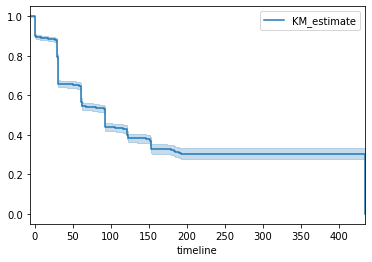

In [31]:
kmf.survival_function_
kmf.cumulative_density_
kmf.median_
kmf.plot_survival_function()

In [0]:
groups = df2['journey']

In [0]:
ix = (groups == 'test')

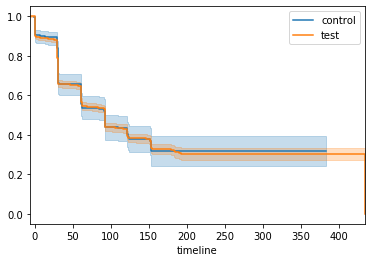

In [34]:
kmf.fit(T[~ix], E[~ix], label='control')
ax = kmf.plot()

kmf.fit(T[ix], E[ix], label='test')
ax = kmf.plot(ax=ax)

In [35]:
#Mean Survival Time for Control 
kmf.fit(T[~ix], E[~ix], label='control')
kmf.median_

/usr/local/lib/python3.6/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


92.0

In [36]:
#Mean Survival time for Onboarding 
kmf.fit(T[ix], E[ix], label='test')
kmf.median_

/usr/local/lib/python3.6/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


92.0

In [0]:
from lifelines.statistics import multivariate_logrank_test

In [0]:
#Setting alpha at 0.95
results = multivariate_logrank_test(df2['tenure_days'], df2['journey'], df2['canceled'],alpha=.95)

In [39]:
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95

---
 test_statistic    p  -log2(p)
           0.07 0.80      0.33


# Product Wise Comparison

In [40]:
kmf.fit(T, event_observed=E,label='Test_and_Control')

<lifelines.KaplanMeierFitter: fitted with 3355 total observations, 1685 right-censored observations>

In [42]:
#Grouping By Subtype and Journey 
df2.groupby(['subtype','journey']).canceled.count()

subtype  journey
P1       control     235
         test       2047
P2       control      44
         test        265
P3       control      62
         test        702
Name: canceled, dtype: int64

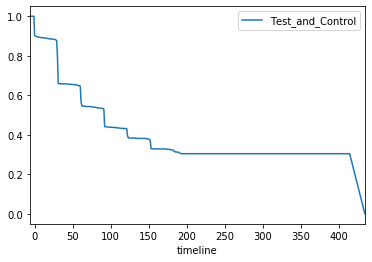

In [43]:

import matplotlib.pyplot as plt 
kmf.survival_function_.plot()
product_types = df2['subtype'].unique()

In [44]:
product_types

array(['P1', 'P2', 'P3'], dtype=object)

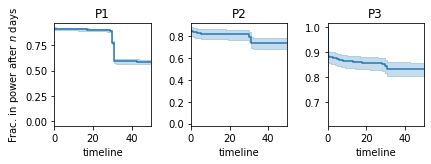

In [45]:
for i, product_type in enumerate(product_types):
    ax = plt.subplot(2, 3, i + 1)

    ix = df2['subtype'] == product_type
    kmf.fit(T[ix], E[ix], label=product_type)
    kmf.plot(ax=ax, legend=False)

    plt.title(product_type)
    plt.xlim(0, 50)

    if i==0:
        plt.ylabel('Frac. in power after $n$ days')

plt.tight_layout()

# Comparing Test and Control for P1

In [0]:
dfr=df2[df2['subtype']=='P1']

Text(0.5, 1.0, 'Survival- Control vs test for P1')

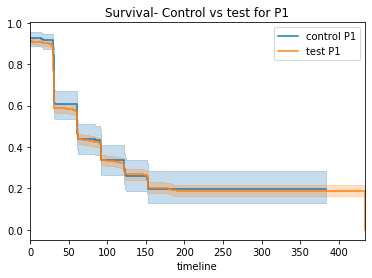

In [47]:
# Need to clean up the data 
T = dfr['tenure_days']
E = dfr['canceled']

from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
#kmf.fit(T, event_observed=E)
#kmf.plot_survival_function()

groups = dfr['journey']
ix = (groups == 'test')

kmf.fit(T[~ix], E[~ix], label='control P1')
ax = kmf.plot()

kmf.fit(T[ix], E[ix], label='test P1')
ax = kmf.plot(ax=ax)
plt.title("Survival- Control vs test for P1")


In [48]:
#Log Rank test to compare Onboarding and Test Group 
from lifelines.statistics import logrank_test
results = logrank_test(T[~ix],T[ix],E[~ix],E[ix])
results.print_summary()

#print(results.p_value) 
#print(results.test_statistic)

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           0.46 0.50      1.00


In [49]:
# Multivariate Log rank Test 
#Same Result as above 
results = multivariate_logrank_test(dfr['tenure_days'], dfr['journey'], dfr['canceled'],alpha=.95)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95

---
 test_statistic    p  -log2(p)
           0.46 0.50      1.00


Text(0.5, 1.0, 'Survival- Control vs test for P1 in first 60 days')

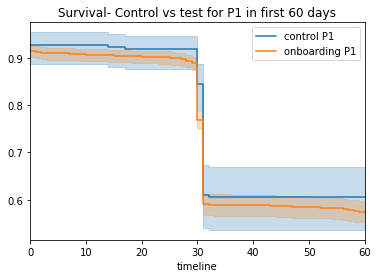

In [51]:
#Survival Comparison in the first 60 days 
import numpy as np
t = np.linspace(0,60,61)
kmf.fit(T[~ix], E[~ix], timeline=t,label='control P1')
ax = kmf.plot()
kmf.fit(T[ix], E[ix],timeline=t,label='onboarding P1')
ax = kmf.plot(ax=ax)
plt.title("Survival- Control vs test for P1 in first 60 days")




In [52]:
#Using Log Rank to Compare the difference between the two groups at a certain point
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
results = survival_difference_at_fixed_point_in_time_test(32,T[~ix],T[ix],E[~ix],E[ix])
results.print_summary()

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 32

---
 test_statistic    p  -log2(p)
           0.20 0.65      0.61


# Restricted Mean Survival Times 

(0, 65)

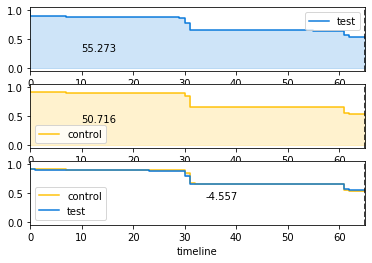

In [53]:
#Comparing test and Onboarding overall
import numpy as np
from lifelines.utils import restricted_mean_survival_time
#from lifelines.datasets import load_waltons

ix = df2['journey'] == 'test'
T, E = df2['tenure_days'], df2['canceled']

kmf_exp = KaplanMeierFitter().fit(T[ix], E[ix], label='test')
kmf_con = KaplanMeierFitter().fit(T[~ix], E[~ix], label='control')

limit = 65

rmst_exp = restricted_mean_survival_time(kmf_exp, t=limit)
rmst_con = restricted_mean_survival_time(kmf_con, t=limit)

ax = plt.subplot(311)
kmf_exp.plot(ax=ax, c="#0C7BDC", ci_show=False)
sf_exp_at_limit = kmf_exp.predict(np.append(kmf_exp.timeline, limit)).sort_index().loc[:limit]
ax.fill_between(sf_exp_at_limit.index, sf_exp_at_limit.values, step='post', color="#0C7BDC", alpha=0.20)
ax.axvline(limit, ls='--', c='k')
ax.text(10, 0.3, "%.3f" % rmst_exp)
ax.set_xlim(0, 65)


ax = plt.subplot(312)
kmf_con.plot(ax=ax, c="#FFC20A", ci_show=False)
sf_con_at_limit = kmf_con.predict(np.append(kmf_con.timeline, limit)).sort_index().loc[:limit]
ax.fill_between(sf_con_at_limit.index, sf_con_at_limit.values, step='post', color="#FFC20A", alpha=0.20)
ax.axvline(limit, ls='--', c='k')
ax.text(10, 0.4, "%.3f" % rmst_con)
ax.set_xlim(0, 65)


ax = plt.subplot(313)
kmf_con.plot(ax=ax, c="#FFC20A", ci_show=False)
kmf_exp.plot(ax=ax, c="#0C7BDC", ci_show=False)
timeline = np.unique(T.tolist() + [limit])
ax.axvline(limit, ls='--', c='k')
ax.fill_between(timeline[timeline<=limit], kmf_con.predict(timeline).loc[:limit], kmf_exp.predict(timeline).loc[:limit], step="post", color='k', alpha=0.10)
ax.text(34, 0.4, "%.3f" % (rmst_con - rmst_exp))
ax.set_xlim(0, 65)



(0, 65)

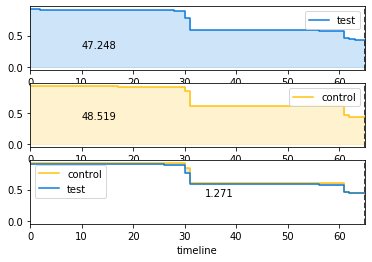

In [54]:
# Restricted mean survival times
# Just for P1 

from lifelines.utils import restricted_mean_survival_time
#from lifelines.datasets import load_waltons

ix = dfr['journey'] == 'test'
T, E = dfr['tenure_days'], dfr['canceled']

kmf_exp = KaplanMeierFitter().fit(T[ix], E[ix], label='test')
kmf_con = KaplanMeierFitter().fit(T[~ix], E[~ix], label='control')

#Setting the limit here 
limit = 65

rmst_exp = restricted_mean_survival_time(kmf_exp, t=limit)
rmst_con = restricted_mean_survival_time(kmf_con, t=limit)

ax = plt.subplot(311)
kmf_exp.plot(ax=ax, c="#0C7BDC", ci_show=False)
sf_exp_at_limit = kmf_exp.predict(np.append(kmf_exp.timeline, limit)).sort_index().loc[:limit]
ax.fill_between(sf_exp_at_limit.index, sf_exp_at_limit.values, step='post', color="#0C7BDC", alpha=0.20)
ax.axvline(limit, ls='--', c='k')
ax.text(10, 0.3, "%.3f" % rmst_exp)
ax.set_xlim(0, 65)


ax = plt.subplot(312)
kmf_con.plot(ax=ax, c="#FFC20A", ci_show=False)
sf_con_at_limit = kmf_con.predict(np.append(kmf_con.timeline, limit)).sort_index().loc[:limit]
ax.fill_between(sf_con_at_limit.index, sf_con_at_limit.values, step='post', color="#FFC20A", alpha=0.20)
ax.axvline(limit, ls='--', c='k')
ax.text(10, 0.4, "%.3f" % rmst_con)
ax.set_xlim(0, 65)


ax = plt.subplot(313)
kmf_con.plot(ax=ax, c="#FFC20A", ci_show=False)
kmf_exp.plot(ax=ax, c="#0C7BDC", ci_show=False)
timeline = np.unique(T.tolist() + [limit])
ax.axvline(limit, ls='--', c='k')
ax.fill_between(timeline[timeline<=limit], kmf_con.predict(timeline).loc[:limit], kmf_exp.predict(timeline).loc[:limit], step="post", color='k', alpha=0.10)
ax.text(34, 0.4, "%.3f" % (rmst_con - rmst_exp))
ax.set_xlim(0, 65)

